In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import keras
from keras import layers
from keras.layers import Activation, Dense
from keras.optimizers import RMSprop
import rbflayer, kmeans_initializer
from rbflayer import InitCentersRandom
from keras.initializers import RandomUniform, Initializer, Constant

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Activation, Dropout
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from scipy import * 
from scipy.linalg import norm, pinv
from matplotlib import pyplot as plt  
import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import keras.backend as K
import numpy as np
 
 
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations
 
 
def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
#from attention_utils import get_activations, get_data
 
np.random.seed(1337)  # for reproducibility
 
from keras.models import *
from keras.layers import Input, Dense,Multiply,Activation
 
input_dim = 4
 
 
 
def Att(att_dim,inputs,name):
    V = inputs
    QK = Dense(att_dim,use_bias=None)(inputs)
    QK = Activation("softmax",name=name)(QK)
    MV = Multiply()([V, QK])
    return(MV)

In [19]:
def build_model():
    inputs = Input(shape=(input_dim,))
 
    atts1 = Att(input_dim,inputs,"attention_vec")
 
    x = Dense(16)(atts1)
    atts2 = Att(16,x,"attention_vec1")
 
 
    output = Dense(1, activation='sigmoid')(atts2)
    model = Model(inputs=inputs, outputs=output)
    return model

In [21]:
N = 10000
inputs_1, outputs = get_data(N, input_dim)

print(inputs_1[:2],outputs[:2])

[[ 1.05427413  1.         -1.73300358 -2.34836064]
 [ 0.11045848  1.         -0.21589959 -0.52714519]] [[1]
 [1]]


In [24]:
inputs_1.shape,outputs.shape

((10000, 4), (10000, 1))

In [25]:
inputs_1

array([[ 1.05427413,  1.        , -1.73300358, -2.34836064],
       [ 0.11045848,  1.        , -0.21589959, -0.52714519],
       [-1.62608443,  0.        , -1.06804895,  0.9379454 ],
       ...,
       [-0.33466576,  1.        ,  1.22777748,  1.70883121],
       [ 0.19871098,  1.        , -0.50357535, -0.55081286],
       [-0.68933405,  0.        ,  0.28214771,  0.66918172]])

[[-0.27979466  1.          0.26975574 -1.35149786]
 [-1.73264006  1.          0.91832546  0.94513606]] [[1]
 [1]]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 4)            16          input_7[0][0]                    
__________________________________________________________________________________________________
attention_vec (Activation)      (None, 4)            0           dense_20[0][0]                   
__________________________________________________________________________________________________
multiply_10 (Multiply)          (None, 4)            0           input_7

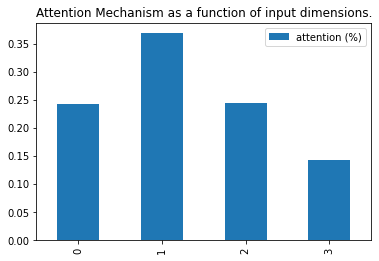

In [20]:
m = build_model()
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

m.fit(inputs_1, outputs, epochs=20, batch_size=128, validation_split=0.2)

testing_inputs_1, testing_outputs = get_data(1, input_dim)

# Attention vector corresponds to the second matrix.
# The first one is the Inputs output.
attention_vector = get_activations(m, testing_inputs_1,
                                   print_shape_only=True,
                                   layer_name='attention_vec')[0].flatten()
print('attention =', attention_vector)

# plot part.


pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                               title='Attention Mechanism as '
                                                                     'a function of input'
                                                                     ' dimensions.')
plt.show()